# Ideas for beta cooling schedule

In [1]:
import numpy as np
from regressor import LinearRegressor

from inversion_ideas import ConjugateGradient, DataMisfit, TikhonovZero

## Create a true model and synthetic data for a linear regressor

In [2]:
n_params = 10
rng = np.random.default_rng(seed=4242)
true_model = rng.uniform(size=10)
true_model

array([0.78225148, 0.67148671, 0.2373809 , 0.17946133, 0.34662367,
       0.15210999, 0.31142952, 0.23900652, 0.54355731, 0.91770851])

In [3]:
# Build the X array
n_data = 25
shape = (n_data, n_params)
X = rng.uniform(size=n_data * n_params).reshape(shape)

In [4]:
synthetic_data = X @ true_model
maxabs = np.max(np.abs(synthetic_data))
noise = rng.normal(scale=1e-2 * maxabs, size=synthetic_data.size)
synthetic_data += noise
synthetic_data

array([2.83840696, 2.18091081, 2.00623242, 2.08333039, 2.01694883,
       2.7826232 , 2.10564027, 1.27333506, 2.08859855, 1.94177648,
       1.88492037, 2.92394733, 2.17231952, 3.08009275, 1.61670886,
       1.77403753, 2.67305005, 1.91413882, 2.42117827, 2.13991628,
       2.0153805 , 2.71388471, 2.65944255, 2.44416121, 3.14217523])

## Define data misfit and smallness

In [5]:
uncertainty = 1e-2 * maxabs * np.ones_like(synthetic_data)
simulation = LinearRegressor(X)
data_misfit = DataMisfit(synthetic_data, uncertainty, simulation)

In [6]:
smallness = TikhonovZero(n_params)

## Solution with fixed beta

In [7]:
phi_fixed = data_misfit + 1e-3 * smallness
initial_model = np.zeros(n_params)
minimizer = ConjugateGradient()
inverted_model = minimizer(phi_fixed, initial_model)
inverted_model

array([0.81328361, 0.65926983, 0.24729306, 0.19624665, 0.32373823,
       0.14720994, 0.31944798, 0.25236328, 0.52215617, 0.92180399])

In [8]:
print("Result:")
print(inverted_model)
print()
print("True model:")
print(true_model)

Result:
[0.81328361 0.65926983 0.24729306 0.19624665 0.32373823 0.14720994
 0.31944798 0.25236328 0.52215617 0.92180399]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


## Apply beta cooling schedule (manually)

In [9]:
minimizer = ConjugateGradient()

In [10]:
n_iters = 10
beta_cooling_factor = 5
initial_model = np.zeros(n_params)
model = initial_model.copy()

# Initialize objective function
beta_0 = 1e2
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Print initial values
dmisfit_value = data_misfit(model)
print(" i  |  beta      | data misfit")
print("------------------------------")

i = 1
while True:
    # Minimize
    model = minimizer(phi, model)
    dmisfit_value = data_misfit(model)
    # Log
    print(f"{i:2d}  |  {regularization.multiplier:.2e}  |  {dmisfit_value:.2e}")
    # Stopping criteria
    if i == n_iters:
        break
    i += 1
    # Cool 
    regularization.multiplier /= beta_cooling_factor

print(model)

 i  |  beta      | data misfit
------------------------------
 1  |  1.00e+02  |  2.47e+01
 2  |  2.00e+01  |  2.80e+00
 3  |  4.00e+00  |  5.11e-01
 4  |  8.00e-01  |  3.75e-01
 5  |  1.60e-01  |  3.69e-01
 6  |  3.20e-02  |  3.69e-01
 7  |  6.40e-03  |  3.69e-01
 8  |  1.28e-03  |  3.69e-01
 9  |  2.56e-04  |  3.69e-01
10  |  5.12e-05  |  3.69e-01
[0.81326129 0.65925401 0.24726512 0.19626775 0.32373033 0.14719308
 0.31947382 0.25235073 0.52216841 0.92184141]


## Use classes

In [11]:
from inversion_ideas import Inversion, MultiplierCooler

In [37]:
# Objective function
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Initial model
initial_model = np.zeros(n_params)

# Minimizer
minimizer = ConjugateGradient()

# Directives
directives = [
    MultiplierCooler(regularization, cooling_factor=2.0),
]

inversion = Inversion(phi, initial_model, minimizer, directives)

In [38]:
chi_target = 0.1
phi_d, phi_m = [], []

In [39]:
for model in inversion:
    
    dmisfit_i, phi_m_i = data_misfit(model), regularization.function(model)
    phi_d.append(dmisfit_i)
    phi_m.append(phi_m_i)
    
    # Compute chi factor
    chi = dmisfit_i / data_misfit.n_data
    
    row = [
        f"{inversion.counter:2d}", 
        f"{regularization.multiplier:.2e}",
        f"{model[0]:.2e}",
        f"{chi:.2e}",
    ]
    print(" | ".join(row))
    
    if chi < chi_target:
        print("Breaking iterations")
        break

 1 | 1.00e+04 | 7.17e-02 | 1.16e+02
 2 | 5.00e+03 | 1.23e-01 | 8.40e+01
 3 | 2.50e+03 | 1.91e-01 | 5.03e+01
 4 | 1.25e+03 | 2.69e-01 | 2.45e+01
 5 | 6.25e+02 | 3.48e-01 | 1.02e+01
 6 | 3.12e+02 | 4.25e-01 | 4.10e+00
 7 | 1.56e+02 | 5.07e-01 | 1.71e+00
 8 | 7.81e+01 | 5.90e-01 | 7.24e-01
 9 | 3.91e+01 | 6.67e-01 | 2.88e-01
10 | 1.95e+01 | 7.26e-01 | 1.08e-01
11 | 9.77e+00 | 7.65e-01 | 4.37e-02
Breaking iterations


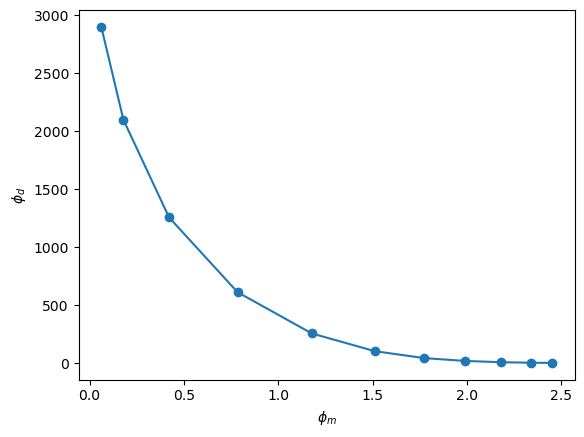

In [40]:
import matplotlib.pyplot as plt

plt.plot(phi_m, phi_d, "o-")
plt.xlabel(r"$\phi_m$")
plt.ylabel(r"$\phi_d$")
plt.show()

In [41]:
true_model

array([0.78225148, 0.67148671, 0.2373809 , 0.17946133, 0.34662367,
       0.15210999, 0.31142952, 0.23900652, 0.54355731, 0.91770851])

In [42]:
model

array([0.76518717, 0.6188566 , 0.24764406, 0.19526216, 0.35131399,
       0.19815277, 0.32923835, 0.27646319, 0.52978942, 0.86908809])